3. data preprocessing

3.1 missing value

For numerical features, median imputation is used because it is robust to outliers observed in chol, trestbps, and oldpeak. For categorical features, mode imputation is appropriate because their values represent discrete clinical categories, and median would produce invalid values

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
data = pd.read_csv('data/heart_disease_uci.csv', index_col=False,)

# numerical & categorical columns names same as part1
continuous_cols = ['age','trestbps','chol','thalch','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal','dataset']

# fill in missing values
for col in continuous_cols:
    data[col] = data[col].fillna(data[col].median())

for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])


/var/folders/z0/5xbc3shs20j2v_h622j6ghpc0000gn/T/ipykernel_11484/353429912.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(data[col].mode()[0])


3.2 outlier and transform

In [15]:
# Outlier clipping
data['chol'] = data['chol'].clip(lower=100, upper=500)
data['trestbps'] = data['trestbps'].clip(lower=80, upper=200)
data['oldpeak'] = data['oldpeak'].clip(lower=0, upper=6)

# Log transform
data['oldpeak'] = np.log1p(data['oldpeak'])

# Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col].astype(str))

3.3 split training and testing set

In [5]:
data.head

<bound method NDFrame.head of       id  age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
0      1   63    1        0   3     145.0  233.0    1        0   150.0      0   
1      2   67    1        0   0     160.0  286.0    0        0   108.0      1   
2      3   67    1        0   0     120.0  229.0    0        0   129.0      1   
3      4   37    1        0   2     130.0  250.0    0        1   187.0      0   
4      5   41    0        0   1     130.0  204.0    0        0   172.0      0   
..   ...  ...  ...      ...  ..       ...    ...  ...      ...     ...    ...   
915  916   54    0        3   0     127.0  333.0    1        2   154.0      0   
916  917   62    1        3   3     130.0  139.0    0        2   140.0      0   
917  918   55    1        3   0     122.0  223.0    1        2   100.0      0   
918  919   58    1        3   0     130.0  385.0    1        0   140.0      0   
919  920   62    1        3   1     120.0  254.0    0        0    93.0      1  

In [16]:
data['target'] = (data['num'] > 0).astype(int)

# Train-test split
X = data.drop(columns=['target','num','id'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

4. modeling

4.1 logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

0.8947871831659493


4.2 XGB modeling baseline

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Baseline XGBoost model
baseline_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss"   
)

# training
baseline_model.fit(X_train, y_train)

# prediction
y_pred_base = baseline_model.predict(X_test)
y_proba_base = baseline_model.predict_proba(X_test)[:, 1]

# evaluation
print("Performance ")
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_base))
print("\nClassification Report:\n", classification_report(y_test, y_pred_base))


Performance 
Accuracy : 0.8586956521739131
ROC-AUC  : 0.9050693448110951

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



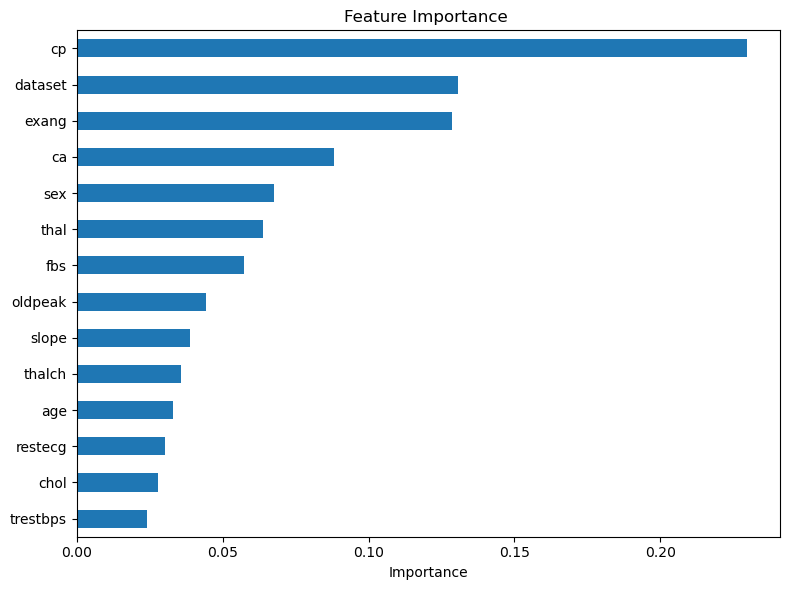

In [18]:
# Feature importance visualization
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    baseline_model.feature_importances_, 
    index=X_train.columns
).sort_values()

plt.figure(figsize=(8, 6))
feature_importance.plot(kind="barh")
plt.title("Feature Importance ")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

4.3 optimizing model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# determine parameter search space
param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5]
}

xgb_clf = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,                # randomly sample 30 parameter combinations
    scoring="roc_auc",      
    cv=5,                     # 5-fold CV
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best AUC score (CV):", random_search.best_score_)
print("Best parameters:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/tangyueyan/miniforge3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:39:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148547996/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tangyueyan/miniforge3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:39:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148547996/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tangyueyan/miniforge3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:39:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148547996/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tangyueyan/miniforge3/envs/ml/lib/python3.11/site-packages/xgboost/tr

Best AUC score (CV): 0.8851145672554885
Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [ ]:
best_model = random_search.best_estimator_
# well fitted XGBoost 
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("New Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_best))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


/Users/tangyueyan/miniforge3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:39:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148547996/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


New Performance
Accuracy : 0.842391304347826
ROC-AUC  : 0.933165949306552

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81        82
           1       0.83      0.90      0.86       102

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



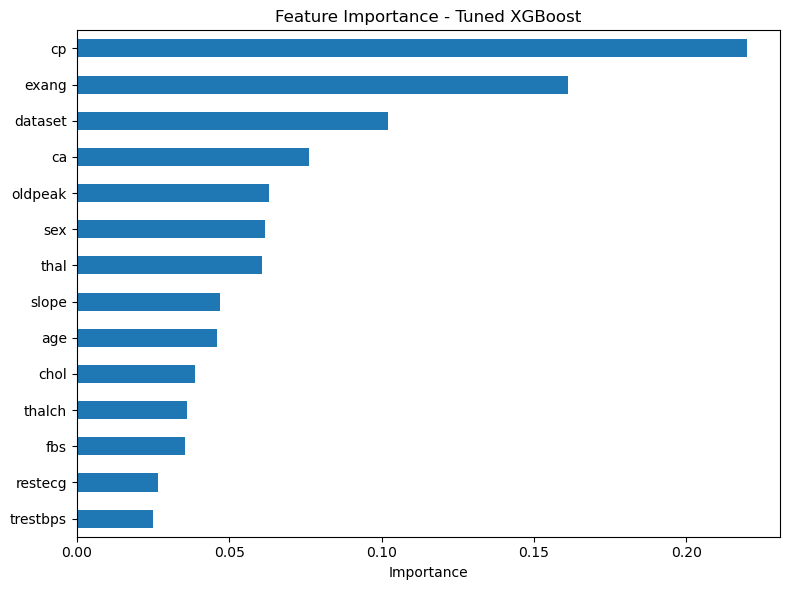

In [21]:
importance_best = pd.Series(
    best_model.feature_importances_, 
    index=X_train.columns
).sort_values()

plt.figure(figsize=(8, 6))
importance_best.plot(kind="barh")
plt.title("Feature Importance - Tuned XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


4.4 shap

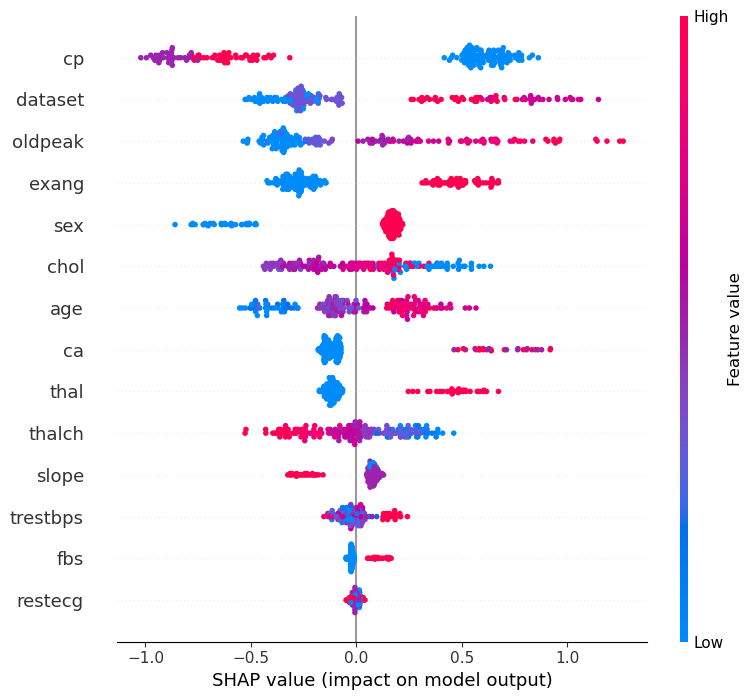

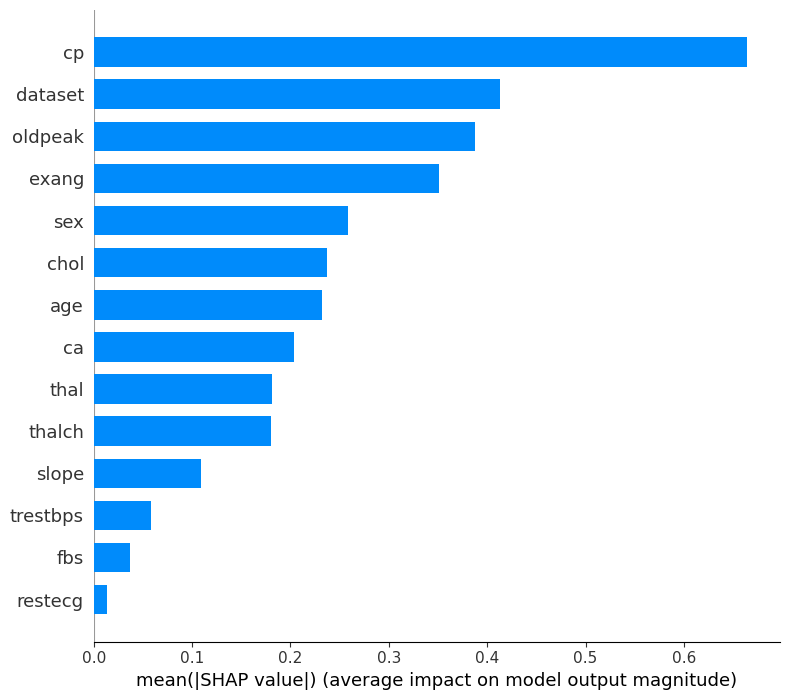

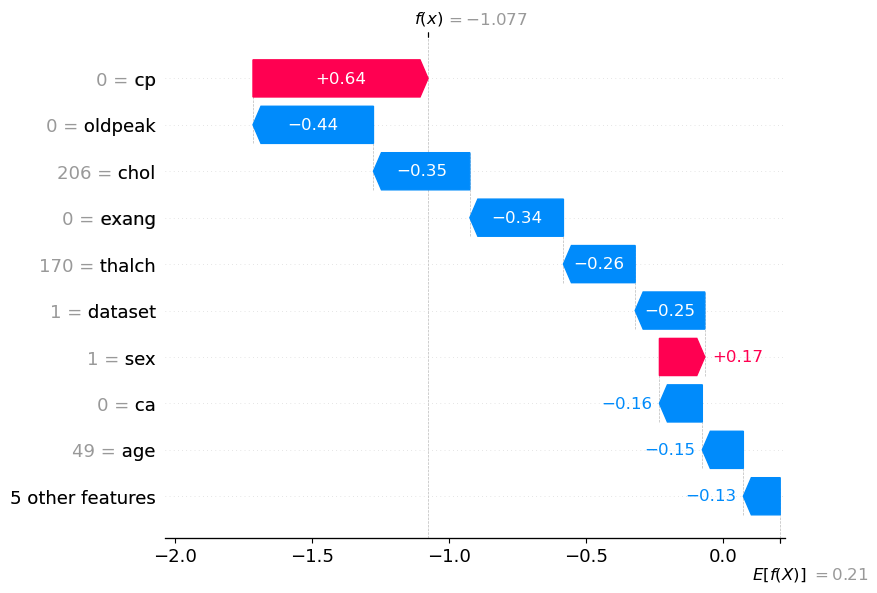

In [ ]:
import shap

# make shap in notebook with JS 
shap.initjs()

# use fitted XGBoost create explainer
explainer = shap.TreeExplainer(best_model)

# calculate SHAP 
shap_values = explainer.shap_values(X_test)
# beeswarm：impression of each feature on prediction
shap.summary_plot(shap_values, X_test, plot_type="dot")
shap.summary_plot(shap_values, X_test, plot_type="bar")

#one sample test
i = 0   # random selected sample index

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_test.iloc[i],
        feature_names=X_test.columns,
    )
)



conclusion

This study developed a structured machine-learning pipeline to predict heart disease using the UCI dataset. Following extensive exploratory data analysis, targeted preprocessing techniques were applied— including outlier clipping, log transformation, and label encoding— to enhance data quality and statistical stability. Logistic Regression was first implemented as a benchmark classifier, achieving an ROC-AUC of approximately 0.89, indicating the presence of meaningful predictive patterns in the dataset.

A more advanced non-linear model, XGBoost, was subsequently introduced. The untuned baseline XGBoost model outperformed Logistic Regression, yielding an ROC-AUC of roughly 0.93. After randomized hyperparameter optimization with five-fold cross-validation, the tuned model demonstrated balanced improvements across accuracy, AUC, precision, and recall, reflecting strong generalization performance.

Model interpretability was further enhanced through SHAP analysis, which quantified both the relative importance and directional influence of individual predictors. Features such as chest pain type, ST depression (oldpeak), and exercise-induced angina emerged as clinically meaningful contributors to risk estimation.

Overall, the optimized XGBoost classifier, supported by SHAP-based explanations, delivers high predictive performance while offering transparent insights into the factors associated with heart-disease prediction.
